In [1]:
import os
import fiona

import numpy as np
import geopandas as gp
import pandas as pd
import rasterio as rio

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pysheds.grid import Grid
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as shPolygon

%matplotlib inline

# Delineate watersheds of the Sierra Nevada
* Use this knowtebook to demo DEM + flow routing algorithms + reservoir locations to delineate upstream catchments; key for reservoir operations, agricultural, and domestic water supply in California

### Get the data and preproces
* Use Digital Elevation Models (DEMs) and flow routing algorithms
* Shuttle radar topography mission (SRTM) DEMS downloaded from: http://srtm.csi.cgiar.org/srtmdata/
* Merged by running from command line: 

`gdal_merge.py -o srtm_dem.tif srtm_12_04.tif srtm_12_05.tif srtm_13_04.tif srtm_13_05.tif srtm_13_06.tif`
    
* Clipped by running from command line:

`gdalwarp -cutline ../shape/cvws.shp -crop_to_cutline srtm_dem.tif hu6_srtm_dem.tif`

### Implement flow routing algorithms
* Use Pysheds package: https://github.com/mdbartos/pysheds (Thanks to @mdbartos for a very nifty package!) 
* (1) DEM --> (2) Flow Direction --> (3) Flow Accumulation --> (4) Adjust Pour Points --> (5) Watershed Delineation

### Load elevation data for CVWS and plot using pysheds


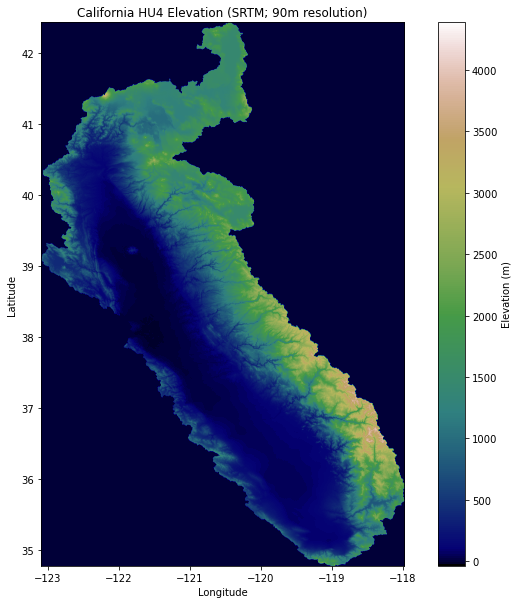

In [2]:
grid = Grid.from_raster('../rasters/hu6_srtm_dem.tif', data_name='dem')

plt.figure(figsize=(12,10))
plt.imshow(grid.dem, extent = grid.extent, cmap = "gist_earth")
plt.title("California HU4 Elevation (SRTM; 90m resolution)")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
cbar = plt.colorbar()
cbar.set_label('Elevation (m)')
plt.show()

### Compute the flow direction from the elevation data

* This computation takes a while (20 mins for 56m px on 4 core mac osx), even though the pysheds is very efficient
* `dirmap` variable corresponds to the the 8 possible directions neighboring a pixel:
* | N | NE | E | SE | S | SW | W | NW |

In [3]:
print("Number of cells = {}".format(str(grid.dem.shape[0]*grid.dem.shape[1])))

Number of cells = 56408180


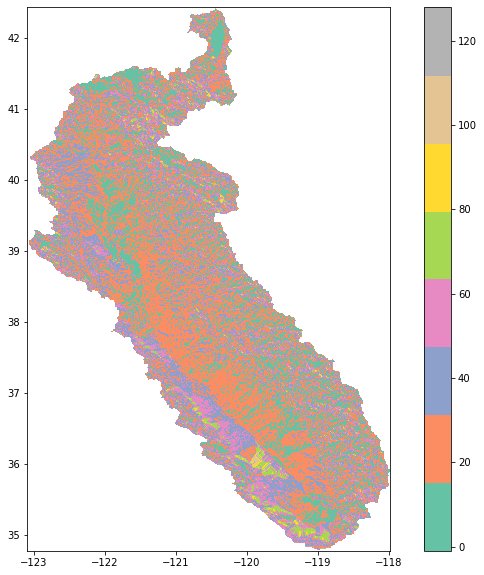

In [4]:
# Chcek if we already have flowdir, if so, load, if not calc

if not os.path.exists("../rasters/flowdir.tif"):
    
    print("Computing flow direction ")

    # Determine D8 flow directions from DEM
    grid = Grid.from_raster('../rasters/hu6_srtm_dem.tif', data_name='dem')

    # Fill depressions in DEM
    grid.fill_depressions('dem', out_name='flooded_dem')

    # Resolve flats in DEM
    grid.resolve_flats('flooded_dem', out_name='inflated_dem')

    # N    NE    E    SE    S    SW    W    NW
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

    # Compute flow directions
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    
else:
    grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')

plt.figure(figsize = (12,10))
cmap = plt.cm.get_cmap('Set2', 8)    # 11 discrete colors
plt.imshow(grid.view('dir'), extent = grid.extent, cmap = cmap)
plt.colorbar()
plt.show()

### Compute flow dir in radians

* Alternatively, map the directions to radians by doing the following: 


In [5]:
# Flowdir to angle mapping
grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')

mapping = {
    64 : np.pi/2,
    128 : np.pi/4,
    1 : 0,
    2 : 7*np.pi/4,
    4 : 3*np.pi/2,
    8 : 5*np.pi/4,
    16 : np.pi,
    32 : 3*np.pi/4,
}


angle = (pd.Series(grid.view('dir', apply_mask=False, nodata=np.nan).ravel())
            .map(mapping).values.reshape(grid.shape))


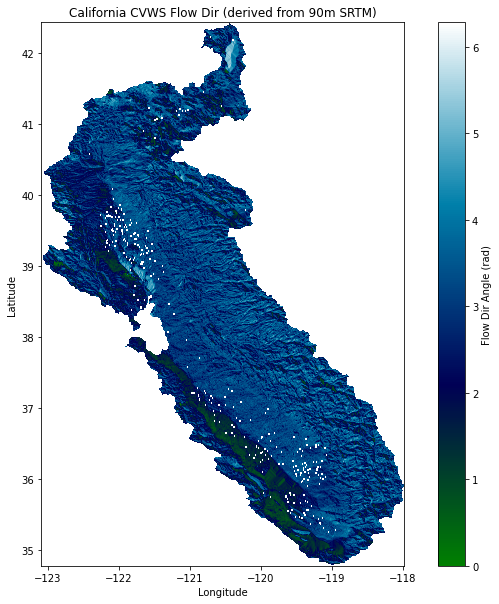

In [6]:
plt.figure(figsize = (12,10))
plt.imshow(angle, cmap='ocean', extent = grid.extent,vmin=0, vmax=2*np.pi, zorder=1)
plt.title("California CVWS Flow Dir (derived from 90m SRTM)")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
cbar = plt.colorbar()
cbar.set_label('Flow Dir Angle (rad)')
plt.show()

* The nans you see here are pixels that do not "flow" to others. I.e. they are sink (I think) 

### Compute flow accumulation

* Flow accumulation is the number of upstream pixels that drain to any given pixel
* We don't actually need this to delineate watersheds, however, it is very useful to position pour points correctly to obtain the correct watershed when doing the delineation. 


In [7]:
# Make a mask for the cv watershed
amask = angle[angle!=np.nan].reshape(angle.shape)
amask[np.isfinite(amask)]=1

# Specify dirmap as above
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Compute flow acc 
grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
grid.accumulation('dir', dirmap=dirmap, out_name='acc')


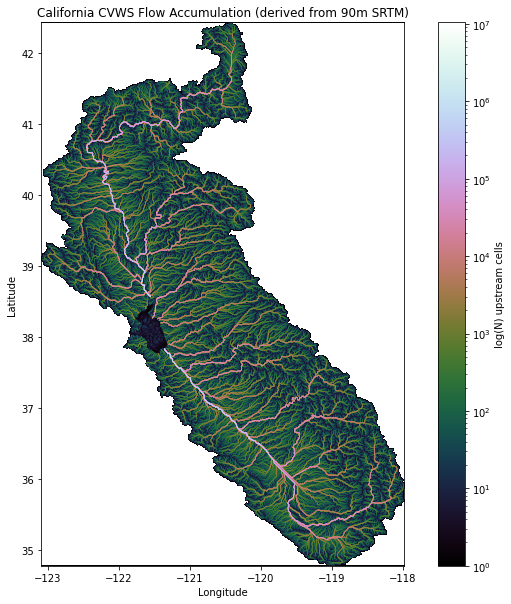

In [8]:
# Plot flow acc

plt.figure(figsize=(12,10))
plt.imshow(grid.view('acc', apply_mask=False), cmap='cubehelix', extent = grid.extent,
                   norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()), zorder=1)
plt.title("California CVWS Flow Accumulation (derived from 90m SRTM)")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
cbar = plt.colorbar()
cbar.set_label('log(N) upstream cells')
plt.show()


### Get the watershed outlets from the reservoirs and gauges shapefile 

The watershed outlets for subwatersheds of the sierra are listed in: Null, S. E., Viers, J. H., & Mount, J. F. (2010). Hydrologic response and watershed sensitivity to climate warming in California's Sierra Nevada. PLoS One, 5(4), e9932.

Table 1: 

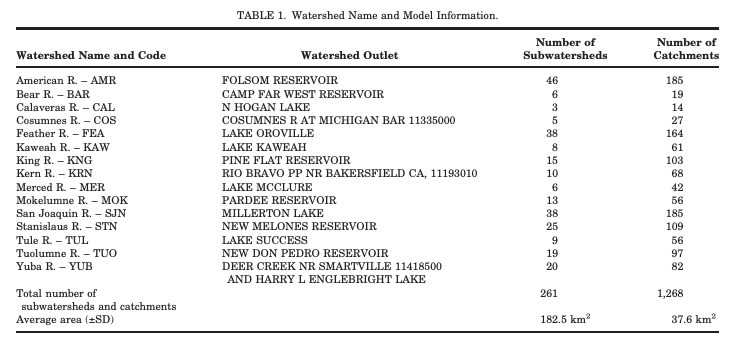

In [9]:
Image(filename='../images/wshed_outlets.png') 

After some research, in contrast with Null et al., (2010), we want to use Isabella Lake instead of the Rio Bravo River for Kern, since reservoir operations affect the downstream gauge. 

#### Filter shapefiles using str matching

In [10]:
# Load the shapefiles
gauges = gp.read_file("../shape/usgs_gauges.shp")
reservoirs = gp.read_file("../shape/reservoirs_grace.shp")

In [11]:
# Filter the gauges - one liner
q_in = gauges[gauges['gauge_id'].isin(['11335000'])]
q_in_lookup = {'11335000': "COSUMNES"}

# Filter the reservoirs based string matching this list:
res_list = ['FOLSOM', 'CAMP', 'HOGAN', 'OROVILLE', 'SHASTA', 'TERMINUS','PINE FLAT', 'MCCLURE',
           'PARDEE', 'MILLERTON', 'MELONES', 'SUCCESS', 'PEDRO', 'ENGLEBRIGHT', "ISABELLA"]

# List of res names to keep
keeps = []
for idx,x in enumerate(list(reservoirs.Station)):
    for i in res_list:
        if i in x:
            keeps.append(x)

# Filter reservoirs for the outlets we want
res_in = reservoirs[reservoirs['Station'].isin(keeps)]

# Concat the gdfs to one object
outlets = pd.concat([res_in,q_in])

# Save as a shapefile
# outlets.to_file("../shape/outlets.shp")

# KEY STEP: Snap the outlets to flowlines

* Unfortunately, there is a manual step that I don't know how to automate. Load the outlets shapefile and Flow Dir raster in Qgis. change the location of the outlet points to fall on the flow acc flowlines. This change is usually not more than a few pixels. The reason this is necessary is the lack of lat/lon precision from USGS / DWR when reporting the coordinates of the reservors / stream gauges.
* This has been done, and the slightly modified file is called `../shape/sierra_outlets.shp`
* The next few blocks (1) get the coordinates of each point (2) calculate the upstream drainage area (3) Write the shapefiles to the `shape` directory

In [12]:
outflows = gp.read_file("../shape/sierra_outlets.shp")

Processing BEAR RIVER AT CAMP FAR WEST DAM


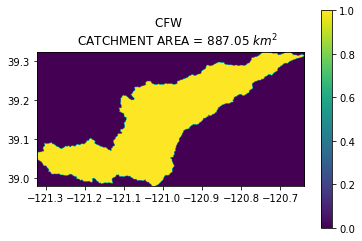

wrote ../shape/catchment_CFW.shp
Processing DON PEDRO RESERVOIR


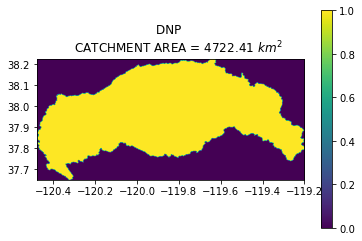

wrote ../shape/catchment_DNP.shp
Processing FOLSOM LAKE


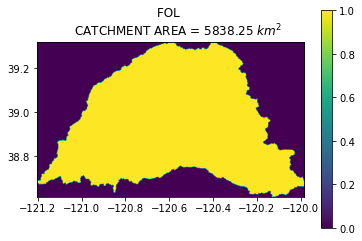

wrote ../shape/catchment_FOL.shp
Processing FRIANT DAM (MILLERTON)


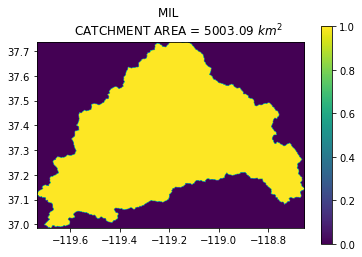

wrote ../shape/catchment_MIL.shp
Processing LAKE MCCLURE


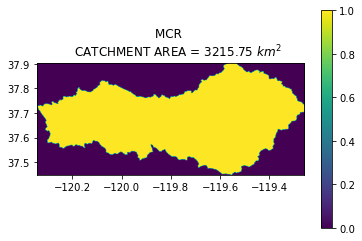

wrote ../shape/catchment_MCR.shp
Processing NEW HOGAN LAKE


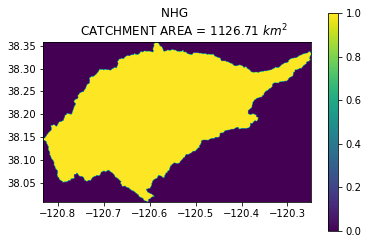

wrote ../shape/catchment_NHG.shp
Processing NEW MELONES RESERVOIR


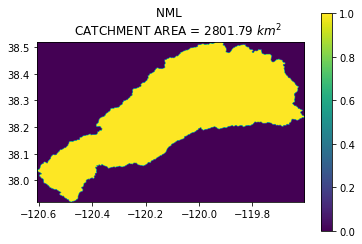

wrote ../shape/catchment_NML.shp
Processing OROVILLE DAM


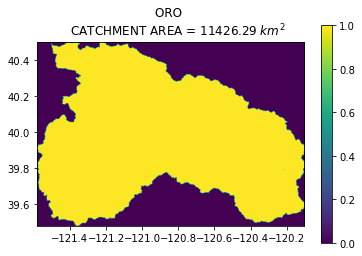

wrote ../shape/catchment_ORO.shp
Processing PARDEE


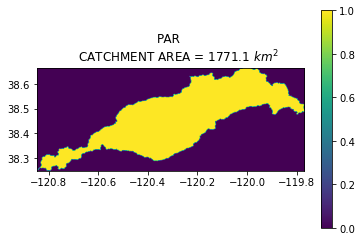

wrote ../shape/catchment_PAR.shp
Processing PINE FLAT DAM


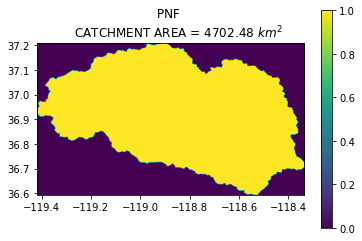

wrote ../shape/catchment_PNF.shp
Processing SHASTA DAM (USBR)


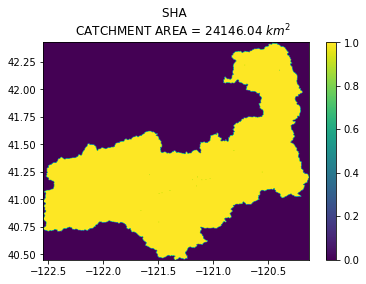

wrote ../shape/catchment_SHA.shp
Processing SUCCESS DAM


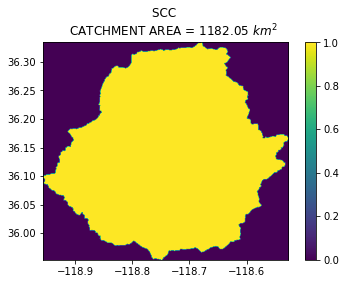

wrote ../shape/catchment_SCC.shp
Processing TERMINUS DAM


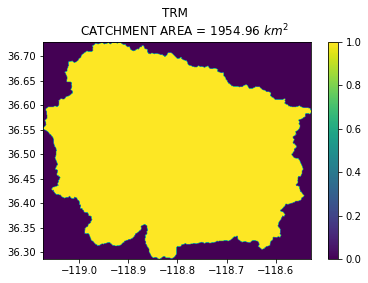

wrote ../shape/catchment_TRM.shp
Processing 11335000


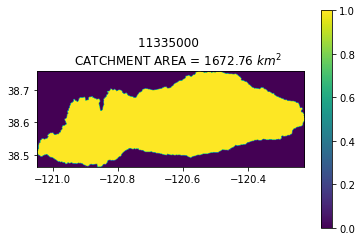

wrote ../shape/catchment_11335000.shp
Processing ENGLEBRIGHT (USACE)


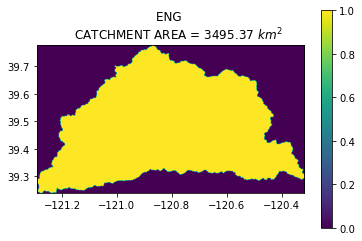

wrote ../shape/catchment_ENG.shp
Processing ISABELLA DAM


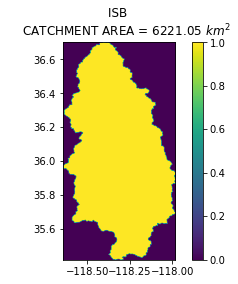

wrote ../shape/catchment_ISB.shp


<Figure size 432x288 with 0 Axes>

In [13]:
# Loop through the outlets, extract the upstream watershed from the flowdir raster from the x,y coordinates

for i in outflows[:].iterrows():
    
    # Reload the grid because we write in place each time
    grid = Grid.from_raster('../rasters/flowdir.tif', data_name='dir')
    # Select outlet from outflows df
    df = outflows.iloc[i[0]]
    x,y = df.geometry.x,df.geometry.y
    
    # Get the attributes to write out from the OG shapefiles
    if not df.Station is None:
        stname = df.Station
        riverB = df['River Basi']
        stid = df.ID
    else:
        stname  = df.gauge_id
        riverB = q_in_lookup[df.gauge_id]
        stid = df.gauge_id
    
    print("Processing "  + stname)
    # Delineate the catchment
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
    
    npix = np.nansum(grid.view('catch') > 0)
    wshed_area = 90*90*int(npix)*1e-6 # calc approximate wshed area for 90m pixels --> sq km

    # Plot the result
    grid.clip_to('catch')
    plt.imshow(grid.view('catch') > 0, extent = grid.extent)  
    plt.title('''{} 
    CATCHMENT AREA = {} $km^2$'''
    .format(stid,str(round(wshed_area,2))))
    
    plt.colorbar()
    plt.show()
    plt.tight_layout()
    
    # Extract as shapefile and write result
    shapes = grid.polygonize()

    shlist = list(shapes)
    for shp in shlist:
        tdf = pd.DataFrame(shp[0])
        if not len((tdf['coordinates'].values)[0]) < 10: # Filter out super small polys (artifacts)
            ptdf = pd.DataFrame(tdf['coordinates'].values[0], columns = ['lon', 'lat'])
            polygon_geom = shPolygon(zip(list(ptdf.lon.values), list(ptdf.lat.values)))
            ptdf2 = ptdf.drop(['lon', 'lat'], axis=1)
            gdf = gp.GeoDataFrame(pd.DataFrame([]), crs="EPSG:4326", geometry= [polygon_geom])
            gdf['outlet_id'] = stname
            gdf['area_km2'] = wshed_area
            gdf['catch_name'] = riverB
            gdf['stid'] = stid
        
    gdf.to_file("../shape/catchment_{}.shp".format(stid))
    print("wrote ../shape/catchment_{}.shp".format(stid))

    print("=======" * 7)
    

In [14]:
# Load the files we just wrote, and plot to sanity check

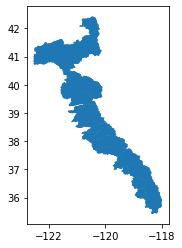

In [15]:
shpdir = "../shape"
catchments = [os.path.join(shpdir,x) for x in os.listdir(shpdir) if "catch" in x if x.endswith(".shp") if "sierra" not in x]
gdfs = [gp.read_file(c) for c in catchments]

scatch = pd.concat(gdfs)
scatch = scatch[~scatch['outlet_id'].isna()] # Drop the small poly artifacts 
scatch.plot()

# Put it all together and plot most of what we just did 

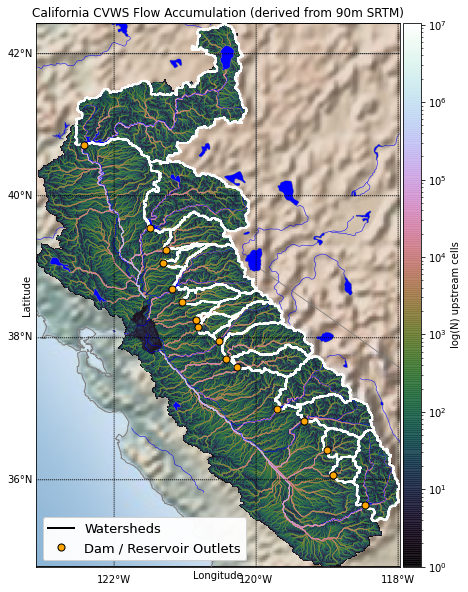

In [16]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)

# Calc flow acc
grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
grid.accumulation('dir', dirmap=dirmap, out_name='acc')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,10))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(scatch, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(outlets,m, alpha = 1,  color= 'orange', edgecolor = 'black')

# Plot flowdir array 
im = m.imshow(np.flipud(grid.view('acc')), cmap='cubehelix', extent = grid.extent,
                   norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()), zorder=1, alpha = 0.9)
ax1.set_title("California CVWS Flow Accumulation (derived from 90m SRTM)")
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='log(N) upstream cells')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

plt.show()

In [ ]:
# scatch.to_file("../shape/sierra_catchments.shp")

In [ ]:
# Calc the distance from outlet of each pixel 
# TODO: Parallelize - This takes FOREVER to run

for i in outflows[:].iterrows():
    
    # Reload the grid because we write in place each time
    grid = Grid.from_raster('../rasters/flowdir.tif', data_name='dir')
    # Select outlet from outflows df
    df = outflows.iloc[i[0]]
    x,y = df.geometry.x,df.geometry.y
    
    # Get the site id
    if not df.Station is None:
        stname = df.Station
    else:
        stname  = df.gauge_id
    
    print("Processing "  + stname)    # Delineate the catchment
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
    
    grid.flow_distance(x, y, 'dir', xytype='label', dirmap=dirmap,
                   out_name='dist', nodata_out=np.nan, method='shortest')
    
    # save
    grid.to_raster('dist', 'flow_dist_{}.tif'.format(stid))
    
    npix = np.nansum(grid.view('catch') > 0)
    wshed_area = 90*90*int(npix)*1e-6

    # Plot the result
    grid.clip_to('catch')
    plt.imshow(grid.view('dist'), extent = grid.extent)  
    plt.title('''{} distance from outlet 
    CATCHMENT AREA = {} $km^2$'''
    .format(stname,str(round(wshed_area,2))))
    
    plt.colorbar()
    plt.show()
    plt.tight_layout()
    
    # Extract as shapefile and write result
    shapes = grid.polygonize()
    write_shapefile(shapes,'../shape/catchment_{}.shp'.format(i[0]))
    
    print("=======" * 7)
    